In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import colors as mcolors
import pathlib
from typing import List, Tuple
import uproot3

In [2]:
ls ~/data/2D_recovery_studies/increased_covmatrix/old

all_2D/        s_0.4/  s_0.82/  s_0.92/  xyz_blowup/
higher_stats/  s_0.5/  s_0.84/  s_0.94/  xyz_seq_highstats_id/
s_0.1/         s_0.6/  s_0.86/  s_0.96/  xyz_seq_withId/
s_0.2/         s_0.7/  s_0.88/  s_0.98/  y_blowup/
s_0.3/         s_0.8/  s_0.9/   s_1/     z_blowup/


In [3]:
input_file = (
    str(pathlib.Path.home())
    + '/data/2D_recovery_studies/increased_covmatrix/xyz_seq/Lb2JPsiL_Run2_Sim_2016_MagUp_v12_with2D.root'
)

In [4]:
save_plots = True

## Pick what extra branches you want
with_dtf = True
with_pidsubs = False
with_protoparticles = True
with_2Ddebug = True
with_truevtx_kinematics = True

## Perform analysis with:
## - All data: 'b' (both)
## - Only Lambdas: 'm' (matter)
## - Only antiLambdas: 'a' (antimatter)
use_matter_antimatter = 'a'

## Choose colors
color_gen = 'tab:gray'
color_3D = 'tab:blue'
color_2D = 'tab:orange'

truth_match = False ## Failed attempt at truth matching, not needed

In [5]:
if use_matter_antimatter == 'b':
    event_category_label = 'All reconstructed events'
elif use_matter_antimatter == 'm':
    event_category_label = 'Only matter events'
elif use_matter_antimatter == 'a':
    event_category_label = 'Only antimatter events'
else:
    raise ValueError

In [6]:
## Create plots directory, if missing
plots_dir = (str(pathlib.Path.home())
                  + '/vertex-reconstruction-studies/'
                  + 'plots/'
                  + 'studies_on_integrated_root_files/'
                  + 'residuals_at_true_vertex_analysis/'
)
pathlib.Path(plots_dir).mkdir(parents=True, exist_ok=True)

# Import data (v2.1)

In [7]:
def root_file_to_df(
    filename: str,
    branches_ordinary: List[str] = [],
    branches_jagged: List[str] = [],   ## These are the protoparticles, really
    truth_tree: bool = False,
    slice_ordinary: bool = True
) -> pd.DataFrame:
    if len(branches_jagged) == 0:
        have_jagged = False
    else:
        have_jagged = True
    
    if len(branches_ordinary) == 0:
        have_ordinary = False
    else:
        have_ordinary = True
    
    with uproot3.open(filename) as file_root:
        if truth_tree:
            tree = file_root['Lb_MC/MCDecayTree']
        else:
            tree = file_root['Lb_T/DecayTree']
        ## Load dataFrame with desired branches
        if have_ordinary:
            if slice_ordinary:
                df_ord = tree.pandas.df(branches_ordinary).loc[(slice(None), 0), :]
            else:
                df_ord = tree.pandas.df(branches_ordinary)
        if have_jagged:
            df_jag = tree.pandas.df(branches_jagged, flatten=False)
            for col in list(df_jag):
                df_jag[col] = df_jag[col].str[0]
        
        if have_ordinary and not have_jagged:
            df = df_ord
        elif not have_ordinary and have_jagged:
            df = df_jag
        elif have_ordinary and have_jagged:
            df = pd.merge(df_ord, df_jag, left_index=True, right_index=True)
            if len(df) != len(df_jag):
                raise ValueError
        else:
            raise ValueError
            
        ## Reset indices
        df.reset_index(drop=True, inplace=True)
        return df

## Reco
### Choose branches

In [8]:
composite_particles = ['Lb', 'L', 'Jpsi']
basic_particles = ['p', 'pim', 'mum', 'mup']
lambda_baryons = ['L', 'Lb']

lambdab_daughters = ['L', 'Jpsi']
lambdab_daughters_DTF = ['Lambda0', 'J_psi_1S']

lambdab_nephews = {
    'L': ['p', 'pim'],
    'Jpsi': ['mum', 'mup'],
}
lambdab_nephews_DTF = {
    'Lambda0': ['pplus', 'piplus'],
    'J_psi_1S': ['muminus_0', 'muminus'],
}

DTF_mass_constraints = ['FixJPsi', 'FixJPsiLambda']

#### Original names

In [9]:
## Reco branches
reco_branches = []
for prefix in composite_particles:
    for component in ['X', 'Y', 'Z']:
        reco_branches.append(prefix + '_ENDVERTEX_' + component)
    reco_branches.append(prefix + '_M')
    reco_branches.append(prefix + '_MM')
        
for prefix in composite_particles + basic_particles:
    for component in ['X', 'Y', 'Z']:
        reco_branches.append(prefix + '_P' + component)
    reco_branches.append(prefix + '_ID')    
    
for prefix in lambda_baryons:
    reco_branches.append(prefix + '_BPVDIRA')
    reco_branches.append(prefix + '_BPVIPCHI2')
    reco_branches.append(prefix + '_BPVVDCHI2')
    reco_branches.append(prefix + '_VFASPF_CHI2_VDOF')
    
for feature in ['X', 'Y', 'Z', 'CHI2', 'NDOF']:
    reco_branches.append('Lb_OWNPV_' + feature)

reco_branches.append('Polarity')

## Truth branches
truth_branches = []

for prefix in lambda_baryons:
    for component in ['X', 'Y', 'Z']:
        truth_branches.append(prefix + '_TRUEENDVERTEX_' + component)
        
for prefix in basic_particles:
    for component in ['X', 'Y', 'Z']:
        truth_branches.append(prefix + '_TRUEP_' + component)

truth_branches.append('L_TRUEID')
truth_branches.append('Lb_TRUEID')
        
for prefix in basic_particles + composite_particles:
    truth_branches.append(prefix + '_Reconstructible')
    truth_branches.append(prefix + '_Reconstructed')

## DTF branches
dtf_branches = []
if with_dtf:
    for mass_constraint in DTF_mass_constraints:
        dtf_branches.append('Lb_DTF_' + mass_constraint + '_status')
        dtf_branches.append('Lb_DTF_' + mass_constraint + '_M')
        dtf_branches.append('Lb_DTF_' + mass_constraint + '_P')
        dtf_branches.append('Lb_DTF_' + mass_constraint + '_chi2')
        dtf_branches.append('Lb_DTF_' + mass_constraint + '_nDOF')
        for feature in ['key', 'X', 'Y', 'Z']:
            dtf_branches.append('Lb_DTF_' + mass_constraint + '_PV_' + feature)

        for mother in lambdab_daughters_DTF:
            dtf_branches.append('Lb_DTF_' + mass_constraint + '_' + mother + '_M')
            dtf_branches.append('Lb_DTF_' + mass_constraint + '_' + mother + '_P')
            dtf_branches.append('Lb_DTF_' + mass_constraint + '_' + mother + '_decayLength')

            for daughter in lambdab_nephews_DTF[mother]:
                for component in ['X', 'Y', 'Z']:
                    dtf_branches.append('Lb_DTF_' + mass_constraint + '_' + mother + '_' + daughter + '_P' + component)

## PIDsubs branches
pidsubs_branches = []
if with_pidsubs:
    for mass_constraint in DTF_mass_constraints:
        pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_status')
        pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_M')
        pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_P')
        pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_chi2')
        pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_nDOF')
        for feature in ['key', 'X', 'Y', 'Z']:
            pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_PV_' + feature)

        for mother in lambdab_daughters_DTF:
            pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_M')
            pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_P')
            pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_decayLength')

            for daughter in lambdab_nephews_DTF[mother]:
                for component in ['X', 'Y', 'Z']:
                    pidsubs_branches.append('Lb_DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_' + daughter + '_P' + component)
                    
    pidsubs_branches.append('TrackType')

## Protoparticle branches
pp_branches = []
if with_protoparticles:
    for part in ['p', 'pim']:
        for feature in ['', 'P']:
            for comp in ['X', 'Y', 'Z']:
                pp_branches.append(part + '_PP_' + feature + comp)
        
        pmc_components = [0, 1, 3, 4, 5] ## 2 is z, all zeros
        
        for row in pmc_components:
            for column in [c for c in pmc_components if c >= row]:
                pp_branches.append(part + '_PP_POSMOMCOV' + '_' +  str(row) +  '_' + str(column))
                
## 2D debug branches
debug_branches = []
if with_2Ddebug:
    debug_branches.append('L_ENDVERTEX_XERR')
    debug_branches.append('L_ENDVERTEX_YERR')
    debug_branches.append('L_ENDVERTEX_ZERR')
    debug_branches.append('L_ALGO_ID')
    
## True vertex kinematics
truevtxkin_branches = []
if with_truevtx_kinematics:
    for kinematic_computation_point in ['AtTrueVtx', 'AtFirstMeas']:
        for prefix in ['p', 'pim']:
            ## Actually no need for z, it's fixed by the transporter
            for component in ['X', 'Y', 'Z']:
                truevtxkin_branches.append(prefix + '_' + kinematic_computation_point + '_REFP_' + component)
                truevtxkin_branches.append(prefix + '_' + kinematic_computation_point + '_REFP_' + component + "ERR")

            for component in ['X', 'Y', 'Z']:
                truevtxkin_branches.append(prefix + '_' + kinematic_computation_point + '_P_' + component)
                truevtxkin_branches.append(prefix + '_' + kinematic_computation_point + '_P_' + component + "ERR")
                
            for component in ['X', 'Y', 'Z']:
                truevtxkin_branches.append('MCTRUTH_' + prefix + '_' + kinematic_computation_point + '_REFP_' + component)
                truevtxkin_branches.append('MCTRUTH_' + prefix + '_' + kinematic_computation_point + '_REFP_' + component + "ERR")

            for component in ['X', 'Y', 'Z']:
                truevtxkin_branches.append('MCTRUTH_' + prefix + '_' + kinematic_computation_point + '_P_' + component)
                truevtxkin_branches.append('MCTRUTH_' + prefix + '_' + kinematic_computation_point + '_P_' + component + "ERR")
    
branches = (
    reco_branches + truth_branches
    + dtf_branches + pidsubs_branches
    + debug_branches + truevtxkin_branches
)

branches_jagged = pp_branches

#### New names

In [10]:
## Reco branches
reco_branches_renamed = []
for prefix in composite_particles:
    for component in ['X', 'Y', 'Z']:
        reco_branches_renamed.append(prefix + '_ENDVERTEX_' + component)
    reco_branches_renamed.append(prefix + '_M')
    reco_branches_renamed.append(prefix + '_MM')
        
for prefix in composite_particles + basic_particles:
    for component in ['X', 'Y', 'Z']:
        reco_branches_renamed.append(prefix + '_P' + component)
    reco_branches_renamed.append(prefix + '_ID')    
    
for prefix in lambda_baryons:
    reco_branches_renamed.append(prefix + '_BPVDIRA')
    reco_branches_renamed.append(prefix + '_BPVIPCHI2')
    reco_branches_renamed.append(prefix + '_BPVVDCHI2')
    reco_branches_renamed.append(prefix + '_VFASPF_CHI2_VDOF')
    
for feature in ['X', 'Y', 'Z', 'CHI2', 'NDOF']:
    reco_branches_renamed.append('Lb_OWNPV_' + feature)

reco_branches_renamed.append('Polarity')

## Truth branches
truth_branches_renamed = []

for prefix in lambda_baryons:
    for component in ['X', 'Y', 'Z']:
        truth_branches_renamed.append('MCTRUTH_' + prefix + '_ENDVERTEX_' + component)
        
for prefix in basic_particles:
    for component in ['X', 'Y', 'Z']:
        truth_branches_renamed.append('MCTRUTH_' + prefix + '_P' + component)

truth_branches_renamed.append('MCTRUTH_L_ID')
truth_branches_renamed.append('MCTRUTH_Lb_ID')
        
for prefix in basic_particles + composite_particles:
    truth_branches_renamed.append('MCTRUTH_' + prefix + '_Reconstructible')
    truth_branches_renamed.append('MCTRUTH_' + prefix + '_Reconstructed')

## DTF branches
dtf_branches_renamed = []
if with_dtf:
    for mass_constraint in DTF_mass_constraints:
        dtf_branches_renamed.append('DTF_' + mass_constraint + '_status')
        dtf_branches_renamed.append('DTF_' + mass_constraint + '_Lb_M')
        dtf_branches_renamed.append('DTF_' + mass_constraint + '_Lb_P')
        dtf_branches_renamed.append('DTF_' + mass_constraint + '_chi2')
        dtf_branches_renamed.append('DTF_' + mass_constraint + '_nDOF')
        for feature in ['key', 'X', 'Y', 'Z']:
            dtf_branches_renamed.append('Lb_DTF_' + mass_constraint + '_PV_' + feature)

        for mother in lambdab_daughters:
            dtf_branches_renamed.append('DTF_' + mass_constraint + '_' + mother + '_M')
            dtf_branches_renamed.append('DTF_' + mass_constraint + '_' + mother + '_P')
            dtf_branches_renamed.append('DTF_' + mass_constraint + '_' + mother + '_decayLength')

            for daughter in lambdab_nephews[mother]:
                for component in ['X', 'Y', 'Z']:
                    dtf_branches_renamed.append('DTF_' + mass_constraint + '_' + daughter + '_P' + component)

## PIDsubs branches
pidsubs_branches_renamed = []
if with_pidsubs:
    for mass_constraint in DTF_mass_constraints:
        pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_status')
        pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_Lb_M')
        pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_Lb_P')
        pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_chi2')
        pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_nDOF')
        for feature in ['key', 'X', 'Y', 'Z']:
            pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_PV_' + feature)

        for mother in lambdab_daughters:
            pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_M')
            pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_P')
            pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_' + mother + '_decayLength')

            for daughter in lambdab_nephews[mother]:
                for component in ['X', 'Y', 'Z']:
                    pidsubs_branches_renamed.append('DTF_' + mass_constraint + '_PIDSubs' + '_' + daughter + '_P' + component)
                    
    pidsubs_branches_renamed.append('TrackType')

## Protoparticle branches
pp_branches_renamed = []
if with_protoparticles:
    for part in ['p', 'pim']:
        for feature in ['', 'P']:
            for comp in ['X', 'Y', 'Z']:
                pp_branches_renamed.append(part + '_PP_' + feature + comp)
        
        pmc_components = [0, 1, 3, 4, 5] ## 2 is z, all zeros
        
        for row in pmc_components:
            for column in [c for c in pmc_components if c >= row]:
                pp_branches_renamed.append(part + '_PP_POSMOMCOV' + '_' +  str(row) +  '_' + str(column))
                
## 2D debug branches
debug_branches_renamed = []
if with_2Ddebug:
    debug_branches_renamed.append('L_ENDVERTEX_XERR')
    debug_branches_renamed.append('L_ENDVERTEX_YERR')
    debug_branches_renamed.append('L_ENDVERTEX_ZERR')
    debug_branches_renamed.append('L_ALGO_ID')

## True vertex kinematics
truevtxkin_branches_renamed = []
if with_truevtx_kinematics:
    for kinematic_computation_point in ['AtTrueVtx', 'AtFirstMeas']:
        for prefix in ['p', 'pim']:
            ## Actually no need for z, it's fixed by the transporter
            for component in ['X', 'Y', 'Z']:
                truevtxkin_branches_renamed.append(prefix + '_' + kinematic_computation_point + '_REFP_' + component)
                truevtxkin_branches_renamed.append(prefix + '_' + kinematic_computation_point + '_REFP_' + component + "ERR")

            for component in ['X', 'Y', 'Z']:
                truevtxkin_branches_renamed.append(prefix + '_' + kinematic_computation_point + '_P_' + component)
                truevtxkin_branches_renamed.append(prefix + '_' + kinematic_computation_point + '_P_' + component + "ERR")
    
            for component in ['X', 'Y', 'Z']:
                truevtxkin_branches_renamed.append('MCTRUTH_' + prefix + '_' + kinematic_computation_point + '_REFP_' + component)
                truevtxkin_branches_renamed.append('MCTRUTH_' + prefix + '_' + kinematic_computation_point + '_REFP_' + component + "ERR")

            for component in ['X', 'Y', 'Z']:
                truevtxkin_branches_renamed.append('MCTRUTH_' + prefix + '_' + kinematic_computation_point + '_P_' + component)
                truevtxkin_branches_renamed.append('MCTRUTH_' + prefix + '_' + kinematic_computation_point + '_P_' + component + "ERR")
                
branches_renamed = (
    reco_branches_renamed + truth_branches_renamed
    + dtf_branches_renamed + pidsubs_branches_renamed
    + debug_branches_renamed + truevtxkin_branches_renamed
)

branches_jagged_renamed = pp_branches_renamed

In [11]:
if len(branches_renamed) != len(branches):
    raise ValueError("Number of ordinary columns before and after renaming does not match.")
    
if len(branches_jagged_renamed) != len(branches_jagged):
    raise ValueError("Number of jagged columns before and after renaming does not match.")

### Import ROOT file

In [12]:
df_reco = root_file_to_df(input_file, branches, branches_jagged)

column_rename_dictionary = {}
for old_name, new_name in zip(branches, branches_renamed):
    column_rename_dictionary[old_name] = new_name
for old_name, new_name in zip(branches_jagged, branches_jagged_renamed):
    column_rename_dictionary[old_name] = new_name
    
df_reco.rename(columns=column_rename_dictionary, inplace=True)

### Replace `ALGO_ID` with intelligible labels

In [13]:
algo_id_dictionary = {
    -10: 'NonConverged',
     -1: 'Unspecified',
      0: 'VertexFitter',
      1: 'XBlownUpAlgorithm',
      2: 'YBlownUpAlgorithm',
      3: 'XYBlownUpAlgorithm',
      4: 'ZBlownUpAlgorithm',
      5: 'XZBlownUpAlgorithm',
      6: 'YZBlownUpAlgorithm',
      7: 'XYZBlownUpAlgorithm',
     10: 'Generic2DAlgorithm',
}

df_reco.replace({'L_ALGO_ID': algo_id_dictionary}, inplace=True)

## Truth

In [14]:
if truth_match:
    truth_match_branches = []
    for part in ['Lb', 'L']:
        for comp in ['X', 'Y', 'Z']:
            truth_match_branches.append(part + '_TRUEENDVERTEX_' + comp)

    for part in ['p', 'pim', 'mum', 'mup']:
        for comp in ['X', 'Y', 'Z']:
            truth_match_branches.append(part + '_TRUEP_' + comp)
        
        truth_match_branches.append(part + '_Reconstructible')
        truth_match_branches.append(part + '_Reconstructed')

    truth_pp_branches = []
    if with_protoparticles:
        for part in ['p', 'pim']:
            for feature in ['', 'P']:
                for comp in ['X', 'Y', 'Z']:
                    truth_pp_branches.append(part + '_PP_' + feature + comp)

            #pmc_components = [0, 1, 3, 4, 5] ## 2 is z, all zeros

            #for row in pmc_components:
            #    for column in [c for c in pmc_components if c >= row]:
            #        truth_pp_branches.append(part + '_PP_POSMOMCOV' + '_' +  str(row) +  '_' + str(column))

    truth_tree_branches_ordinary = truth_match_branches
    truth_tree_branches_jagged = truth_pp_branches

In [15]:
if truth_match:
    truth_match_branches_renamed = []
    for part in ['Lb', 'L']:
        for comp in ['X', 'Y', 'Z']:
            truth_match_branches_renamed.append('MCTRUTH_' + part + '_ENDVERTEX_' + comp)

    for part in ['p', 'pim', 'mum', 'mup']:
        for comp in ['X', 'Y', 'Z']:
            truth_match_branches_renamed.append('MCTRUTH_' + part + '_P' + comp)

        truth_match_branches_renamed.append('MCTRUTH_' + part + '_Reconstructible')
        truth_match_branches_renamed.append('MCTRUTH_' + part + '_Reconstructed')
            
    truth_pp_branches_renamed = []
    if with_protoparticles:
        for part in ['p', 'pim']:
            for feature in ['', 'P']:
                for comp in ['X', 'Y', 'Z']:
                    truth_pp_branches_renamed.append('MCTRUTH_' + part + '_PP_' + feature + comp)

            #pmc_components = [0, 1, 3, 4, 5] ## 2 is z, all zeros

            #for row in pmc_components:
            #    for column in [c for c in pmc_components if c >= row]:
            #        truth_pp_branches_renamed.append('MCTRUTH_' + part + '_PP_POSMOMCOV' + '_' +  str(row) +  '_' + str(column))

    truth_tree_branches_ordinary_renamed = truth_match_branches_renamed
    truth_tree_branches_jagged_renamed = truth_pp_branches_renamed

In [16]:
if truth_match:
    if len(truth_tree_branches_ordinary) != len(truth_tree_branches_ordinary_renamed):
        raise ValueError("Number of ordinary columns before and after renaming does not match.")

    if len(truth_tree_branches_jagged) != len(truth_tree_branches_jagged_renamed):
        raise ValueError("Number of ordinary columns before and after renaming does not match.")

In [17]:
if truth_match:
    df_truth = root_file_to_df(input_file,
                               branches_ordinary=truth_tree_branches_ordinary,
                               branches_jagged=truth_tree_branches_jagged,
                               truth_tree=True,
                               slice_ordinary=False)

    column_rename_dictionary = {}
    for old_name, new_name in zip(truth_tree_branches_jagged, truth_tree_branches_jagged_renamed):
        column_rename_dictionary[old_name] = new_name

    for old_name, new_name in zip(truth_tree_branches_ordinary, truth_tree_branches_ordinary_renamed):
        column_rename_dictionary[old_name] = new_name

    df_truth.rename(columns=column_rename_dictionary, inplace=True)
    df_truth

## Merge truth and reco
This includes "truth matching", i.e. taking out whatever isn't signal.

In [18]:
if truth_match:
    columns_for_long_key = [
        'MCTRUTH_Lb_ENDVERTEX_X',
        'MCTRUTH_Lb_ENDVERTEX_Y',
        'MCTRUTH_Lb_ENDVERTEX_Z',
        'MCTRUTH_L_ENDVERTEX_X',
        'MCTRUTH_L_ENDVERTEX_Y',
        'MCTRUTH_L_ENDVERTEX_Z',
        'MCTRUTH_p_PX',
        'MCTRUTH_p_PY',
        'MCTRUTH_p_PZ',
        'MCTRUTH_pim_PX',
        'MCTRUTH_pim_PY',
        'MCTRUTH_pim_PZ',
        'MCTRUTH_mum_PX',
        'MCTRUTH_mum_PY',
        'MCTRUTH_mum_PZ',
        'MCTRUTH_mup_PX',
        'MCTRUTH_mup_PY',
        'MCTRUTH_mup_PZ',
    ]

In [19]:
if truth_match:
    df_reco['MC_longkey'] = df_reco.loc[:, columns_for_long_key].agg(lambda x : struct.pack('f' * len(columns_for_long_key), *x), axis='columns')
    df_truth['MC_longkey'] = df_reco.loc[:, columns_for_long_key].agg(lambda x : struct.pack('f' * len(columns_for_long_key), *x), axis='columns')
    
    df_truth.drop(columns=columns_for_long_key, inplace=True)
    
    df_truth['MC_key'] = df_truth.index
    df_reco['Rec_key'] = df_reco.index
    
    df_reco = pd.merge(df_reco, df_truth.loc[:, ['MC_longkey', 'MC_key']], on='MC_longkey', how='left')
    
    df_reco['TrackType'] = 'T'
    
    df_MC_grouped = df_reco.loc[:, ['MC_longkey', 'Rec_key', 'TrackType']].groupby('MC_longkey').agg({'Rec_key' : ['min', 'count'], 'TrackType' : ['first']}).reset_index()
    df_MC_grouped.columns = ['MC_longkey', 'Rec_key', 'N_rec_matches', 'TrackType']
    df_truth = pd.merge(df_truth, df_MC_grouped, on='MC_longkey', how='left')
    df_truth['TrackType'] = df_truth['TrackType'].fillna('NA').astype(dtype='category')

    df_reco.drop('MC_longkey', inplace=True, axis='columns')
    df_truth.drop('MC_longkey', inplace=True, axis='columns')
    
    df_reco.index.name = 'Rec_key'
    df_reco.drop('Rec_key', inplace=True, axis='columns')
    df_truth.index.name = 'MC_key'
    df_truth.drop('MC_key', inplace=True, axis='columns')

    # Downcasting the keys and counters
    df_reco['MC_key'] = pd.to_numeric(df_reco['MC_key'].fillna(-1), downcast='signed')
    df_truth['Rec_key'] = pd.to_numeric(df_truth['Rec_key'].fillna(-1), downcast='signed')
    df_truth['N_rec_matches'] = pd.to_numeric(df_truth['N_rec_matches'].fillna(0), downcast='unsigned')

In [20]:
if truth_match:
    df_events = pd.merge(df_truth, df_reco.loc[df_reco['MC_key'] >= 0, :].drop('TrackType', axis='columns').groupby('MC_key').first(), how='left', on='MC_key')

## If we don't want the truth info...

In [21]:
if not truth_match:
    df_events = df_reco
    del(df_reco)

# Apply further selections
## Select matter/antimatter

In [22]:
if not use_matter_antimatter == 'b':
    if use_matter_antimatter == 'm':
        Lb_ID_constraint = 5122
    elif use_matter_antimatter == 'a':
        Lb_ID_constraint = -5122
    else:
        raise ValueError
    
    df_events = df_events.loc[df_events['MCTRUTH_Lb_ID'] == Lb_ID_constraint]

In [23]:
df_events

,Lb_ENDVERTEX_X,Lb_ENDVERTEX_Y,Lb_ENDVERTEX_Z,Lb_M,Lb_MM,L_ENDVERTEX_X,L_ENDVERTEX_Y,L_ENDVERTEX_Z,L_M,L_MM,...,pim_PP_POSMOMCOV_1_1,pim_PP_POSMOMCOV_1_3,pim_PP_POSMOMCOV_1_4,pim_PP_POSMOMCOV_1_5,pim_PP_POSMOMCOV_3_3,pim_PP_POSMOMCOV_3_4,pim_PP_POSMOMCOV_3_5,pim_PP_POSMOMCOV_4_4,pim_PP_POSMOMCOV_4_5,pim_PP_POSMOMCOV_5_5
0,1.674753,0.053259,0.004623,5548.595304,5994.525949,461.983261,-78.247981,6504.222043,1098.518302,1116.608101,...,0.156104,0.054083,-1.250532,1.336292,135.629715,-9.136084,3.142556e+03,17.418783,-213.811951,7.316263e+04
2,0.893069,-0.210212,27.346294,5669.609293,5447.484208,84.953310,-116.199707,5557.096303,1196.546077,1204.210206,...,0.156974,-0.272185,-2.498910,9.883920,760.612305,745.142334,-2.886078e+04,787.374390,-28372.277344,1.099216e+06
4,0.636031,-0.090822,-65.799311,5666.024183,5523.351851,-207.686722,152.674077,7297.794399,1142.059990,1140.502451,...,0.171479,0.277545,-2.941218,-7.591522,503.966400,-231.546097,-1.309437e+04,201.608795,6041.502441,3.405917e+05
9,1.617035,-0.821472,-39.854365,5936.086783,5499.830282,333.851078,-128.470374,5980.635167,1176.696831,1156.693815,...,7.436529,356.552612,-304.435455,10432.956055,42403.156250,-27745.437500,1.227557e+06,19486.900391,-805033.562500,3.554504e+07
11,0.874762,-0.223927,35.888694,5426.497098,5616.278297,98.739317,-84.801436,6546.290665,1094.326789,1094.371201,...,0.156737,-0.018937,-2.312901,7.777235,2.931918,14.396604,-1.062213e+03,155.057129,-7702.167969,5.707532e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1284,1.029511,-0.230128,-20.454931,5977.315257,5662.073968,593.077632,193.184027,4914.675864,1727.341693,1561.371444,...,2.062383,-7.658329,-7.315614,73.758316,4175.534668,-2056.081787,-4.163603e+04,1098.118164,20557.689453,4.159391e+05
1285,1.101364,-0.737077,67.994382,-8364.634549,9946.496456,363.661658,-55.080362,5695.448012,1874.557415,1647.235689,...,0.198738,0.125811,-0.700255,-1.477443,333.006622,88.687401,-4.307514e+03,32.753529,-1153.531860,5.604915e+04
1286,1.101831,-0.738614,67.996588,-8958.541951,9208.223749,380.401838,-66.608245,5851.400767,1035.540220,1181.168672,...,0.198738,0.125811,-0.700255,-1.477443,333.006622,88.687401,-4.307514e+03,32.753529,-1153.531860,5.604915e+04
1287,1.102002,-0.738529,67.994842,4457.971071,4454.376071,417.663023,-71.699471,6060.194347,976.451341,1101.805233,...,0.198738,0.125811,-0.700255,-1.477443,333.006622,88.687401,-4.307514e+03,32.753529,-1153.531860,5.604915e+04


# Helper functions

In [24]:
def plot_single_histogram(
    series: pd.Series, ## Series built from df columns. May be a column itself
    axis_label: str,
    plot_title: str,
    file_name: str,
    binning: int,
    boundaries: Tuple[float],
    log_scale: bool = False,
    scientific_notation: bool = False,
    normalized: bool = True,
    median_line: bool = False
):
    
    plt.hist(
        series,
        bins=binning,
        range=boundaries,
        histtype='stepfilled',
        edgecolor=color_gen,
        color=mcolors.to_rgba(color_gen, alpha=0.05),
        density=normalized
    )
    
    plt.grid()
    plt.xlabel(axis_label)
    plt.title(plot_title)
    
    if log_scale:
        plt.yscale('log')

    if normalized:
        plt.ylabel("Probability density")
    else:
        plt.ylabel("Events")
        
    if median_line:
        plt.axvline(x=series.median(), ymin=0, ymax=1, label='Median', color='black', linestyle='--')
        plt.legend()
    
    if scientific_notation:
        plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    
    if save_plots:
        plt.savefig(plots_dir + file_name + '.pdf', bbox_inches='tight')
    
    plt.show()

In [25]:
def plot_2D_vs_3D_histograms(
    df: pd.DataFrame, ## Full DataFrame
    series: pd.Series, ## Series built from df columns. May be a column itself
    axis_label: str,
    plot_title: str,
    file_name: str,
    binning: int,
    boundaries: Tuple[float],
    log_scale: bool = False,
    scientific_notation: bool = False,
    normalized: bool = True
):
    is_VF = df_events['L_ALGO_ID'] == 'VertexFitter'
    counts_VF = sum(is_VF)
    counts_2D = sum(~is_VF)
    
    ## 3D-converged events
    plt.hist(
        series.loc[is_VF],
        bins=binning,
        range=boundaries,
        #label="VF (" + str(counts_VF) + " evts)",
        label="Standard reconstructed",
        histtype='stepfilled',
        edgecolor=color_3D,
        color=mcolors.to_rgba(color_3D, alpha=0.05),
        density=normalized
    )
    
    ## Failed
    plt.hist(
        series.loc[~is_VF],
         bins=binning,
         range=boundaries,
         #label="2D-XYZ (" + str(counts_2D) + " evts)",
         label="Recovered",
         histtype='stepfilled',
         edgecolor=color_2D,
         color=mcolors.to_rgba(color_2D, alpha=0.05),
         density=normalized
    )
    
    plt.grid()
    plt.xlabel(axis_label)
    plt.title(plot_title)
    
    if log_scale:
        plt.yscale('log')

    if normalized:
        plt.ylabel("Probability density")
    else:
        plt.ylabel("Events")
    
    plt.legend()
    
    if scientific_notation:
        plt.ticklabel_format(axis="x", style="sci", scilimits=(0,0))
    
    if save_plots:
        plt.savefig(plots_dir + file_name + '.pdf', bbox_inches='tight')
    
    plt.show()

In [26]:
def plot_single_hist2D(
    series_x: pd.Series,
    series_y: pd.Series,
    label_x: str,
    label_y: str,
    range_x: List[float],
    range_y: List[float],
    title: str,
    binning: int,
    file_name: str,
    show_title: bool = True,
    black_and_white: bool = False
) -> None:
    
    plot_params = {
        'range': [range_x, range_y],
        'bins': binning
    }
    
    if black_and_white:
        plot_params['cmap'] = 'gray'
    else:
        plot_params['cmap'] = 'turbo'
        
    plt.hist2d(series_x, series_y, **plot_params)
    
    if show_title:
        plt.title(title)
    
    plt.xlabel(label_x)
    plt.ylabel(label_y)
    plt.colorbar(label='Events')
    
    plt.show()

# Residuals study
First some basic analysis: compare reference points of particles at $z_{vtx}^{true}$ with the true values.

## Proton reference point

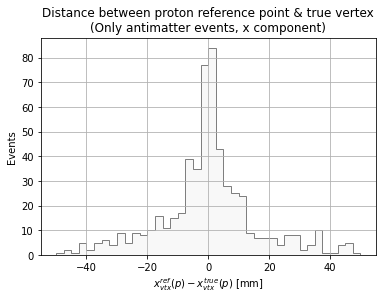

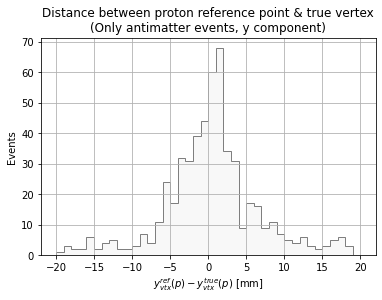

In [27]:
bias_boundary_dictionary = {
    'x': (-50,50),
    'y': (-20,20),
}

for comp in ['x', 'y']:
    reco_feature = 'p_AtTrueVtx_REFP_' + comp.upper()
    true_feature = 'MCTRUTH_L_ENDVERTEX_' + comp.upper()

    plot_args = {
        'axis_label': '$' + comp + '^{ref}_{vtx}(p) - ' + comp + '^{true}_{vtx}(p)$ [mm]',
        'plot_title': 'Distance between proton reference point & true vertex\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'p_refpoint_residual_' + comp,
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': False,
        'normalized': False
    }

    plot_single_histogram(
        df_events[reco_feature] - df_events[true_feature],
        **plot_args)

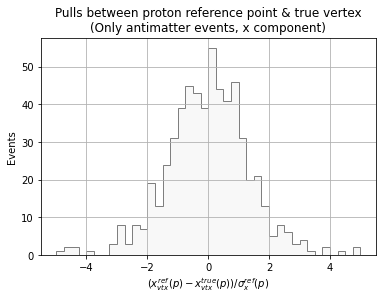

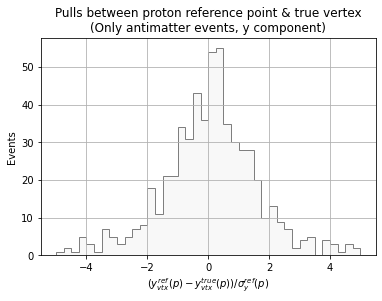

In [28]:
bias_boundary_dictionary = {
    'x': (-5,5),
    'y': (-5,5),
}

for comp in ['x', 'y']:
    reco_feature = 'p_AtTrueVtx_REFP_' + comp.upper()
    true_feature = 'MCTRUTH_L_ENDVERTEX_' + comp.upper()
    reco_error = 'p_AtTrueVtx_REFP_' + comp.upper() + 'ERR'

    plot_args = {
        'axis_label': '$(' + comp + '^{ref}_{vtx}(p) - ' + comp + '^{true}_{vtx}(p))/\sigma_' +  comp + '^{ref} (p)$',
        'plot_title': 'Pulls between proton reference point & true vertex\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'p_refpoint_residual_' + comp + '_rel',
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': False,
        'normalized': False
    }

    plot_single_histogram(
        (df_events[reco_feature] - df_events[true_feature])/df_events[reco_error],
        **plot_args)

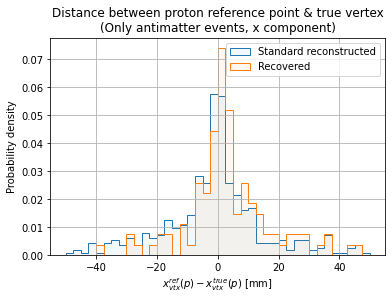

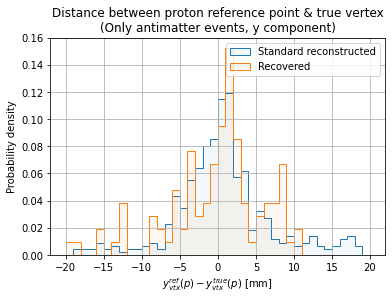

In [29]:
bias_boundary_dictionary = {
    'x': (-50,50),
    'y': (-20,20),
}

for comp in ['x', 'y']:
    reco_feature = 'p_AtTrueVtx_REFP_' + comp.upper()
    true_feature = 'MCTRUTH_L_ENDVERTEX_' + comp.upper()

    plot_args = {
        'axis_label': '$' + comp + '^{ref}_{vtx}(p) - ' + comp + '^{true}_{vtx} (p)$ [mm]',
        'plot_title': 'Distance between proton reference point & true vertex\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'p_refpoint_residual_2Dv3D_' + comp,
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': False,
        'normalized': True
    }

    plot_2D_vs_3D_histograms(
        df_events,
        df_events[reco_feature] - df_events[true_feature],
        **plot_args)

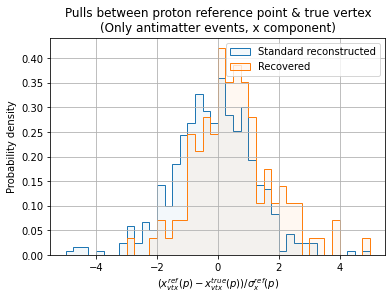

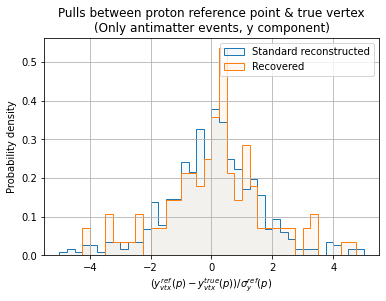

In [30]:
bias_boundary_dictionary = {
    'x': (-5,5),
    'y': (-5,5),
}

for comp in ['x', 'y']:
    reco_feature = 'p_AtTrueVtx_REFP_' + comp.upper()
    true_feature = 'MCTRUTH_L_ENDVERTEX_' + comp.upper()
    reco_error = 'p_AtTrueVtx_REFP_' + comp.upper() + 'ERR'

    plot_args = {
        'axis_label': '$(' + comp + '^{ref}_{vtx}(p) - ' + comp + '^{true}_{vtx}(p))/\sigma_' +  comp + '^{ref} (p)$',
        'plot_title': 'Pulls between proton reference point & true vertex\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'p_refpoint_residual_2Dv3D_' + comp + '_rel',
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': False,
        'normalized': True
    }

    plot_2D_vs_3D_histograms(
        df_events,
        (df_events[reco_feature] - df_events[true_feature])/df_events[reco_error],
        **plot_args)

## Pion reference point

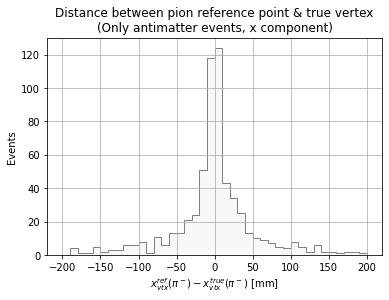

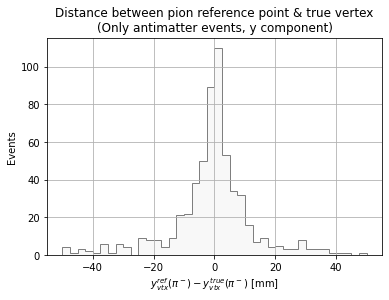

In [31]:
bias_boundary_dictionary = {
    'x': (-200,200),
    'y': (-50,50),
}

for comp in ['x', 'y']:
    reco_feature = 'pim_AtTrueVtx_REFP_' + comp.upper()
    true_feature = 'MCTRUTH_L_ENDVERTEX_' + comp.upper()

    plot_args = {
        'axis_label': '$' + comp + '^{ref}_{vtx}(\pi^-) - ' + comp + '^{true}_{vtx}(\pi^-)$ [mm]',
        'plot_title': 'Distance between pion reference point & true vertex\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'pim_refpoint_residual_' + comp,
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': False,
        'normalized': False
    }

    plot_single_histogram(
        df_events[reco_feature] - df_events[true_feature],
        **plot_args)

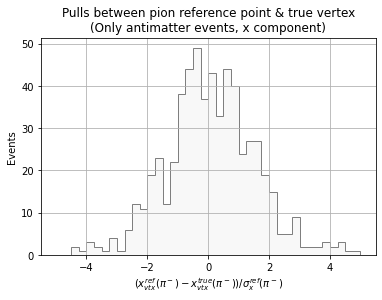

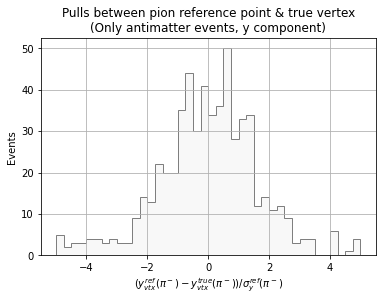

In [32]:
bias_boundary_dictionary = {
    'x': (-5,5),
    'y': (-5,5),
}

for comp in ['x', 'y']:
    reco_feature = 'pim_AtTrueVtx_REFP_' + comp.upper()
    true_feature = 'MCTRUTH_L_ENDVERTEX_' + comp.upper()
    reco_error = 'pim_AtTrueVtx_REFP_' + comp.upper() + 'ERR'

    plot_args = {
        'axis_label': '$(' + comp + '^{ref}_{vtx}(\pi^-) - ' + comp + '^{true}_{vtx}(\pi^-))/\sigma_' +  comp + '^{ref} (\pi^-)$',
        'plot_title': 'Pulls between pion reference point & true vertex\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'pim_refpoint_residual_' + comp + '_rel',
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': False,
        'normalized': False
    }

    plot_single_histogram(
        (df_events[reco_feature] - df_events[true_feature])/df_events[reco_error],
        **plot_args)

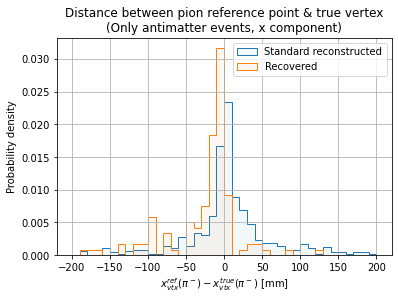

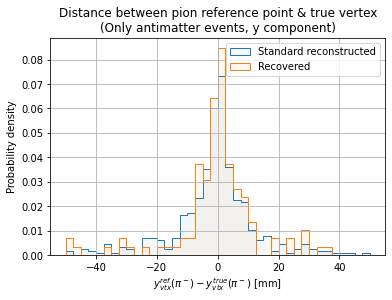

In [33]:
bias_boundary_dictionary = {
    'x': (-200,200),
    'y': (-50,50),
}

for comp in ['x', 'y']:
    reco_feature = 'pim_AtTrueVtx_REFP_' + comp.upper()
    true_feature = 'MCTRUTH_L_ENDVERTEX_' + comp.upper()

    plot_args = {
        'axis_label': '$' + comp + '^{ref}_{vtx}(\pi^-) - ' + comp + '^{true}_{vtx} (\pi^-)$ [mm]',
        'plot_title': 'Distance between pion reference point & true vertex\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'pim_refpoint_residual_2Dv3D_' + comp,
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': False,
        'normalized': True
    }

    plot_2D_vs_3D_histograms(
        df_events,
        df_events[reco_feature] - df_events[true_feature],
        **plot_args)

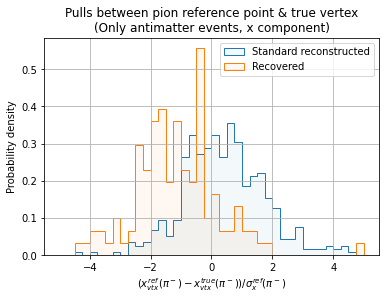

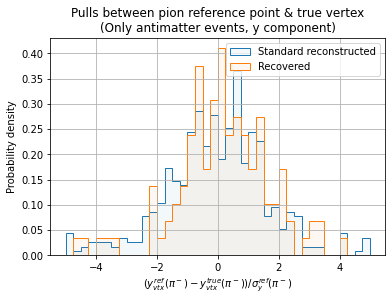

In [34]:
bias_boundary_dictionary = {
    'x': (-5,5),
    'y': (-5,5),
}

for comp in ['x', 'y']:
    reco_feature = 'pim_AtTrueVtx_REFP_' + comp.upper()
    true_feature = 'MCTRUTH_L_ENDVERTEX_' + comp.upper()
    reco_error = 'pim_AtTrueVtx_REFP_' + comp.upper() + 'ERR'

    plot_args = {
        'axis_label': '$(' + comp + '^{ref}_{vtx}(\pi^-) - ' + comp + '^{true}_{vtx}(\pi^-))/\sigma_' +  comp + '^{ref} (\pi^-)$',
        'plot_title': 'Pulls between pion reference point & true vertex\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'pim_refpoint_residual_2Dv3D_' + comp + '_rel',
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': False,
        'normalized': True
    }

    plot_2D_vs_3D_histograms(
        df_events,
        (df_events[reco_feature] - df_events[true_feature])/df_events[reco_error],
        **plot_args)

## Proton momentum


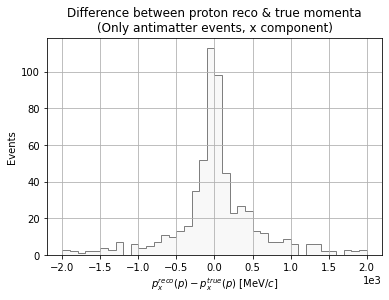

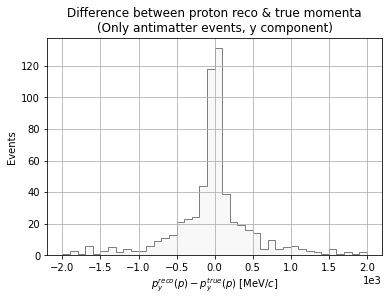

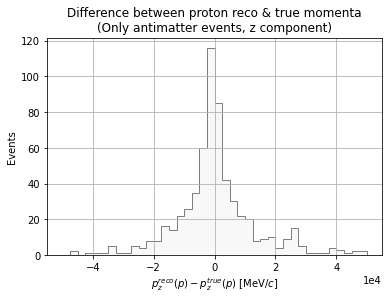

In [35]:
bias_boundary_dictionary = {
    'x': (-2e3,2e3),
    'y': (-2e3,2e3),
    'z': (-5e4,5e4)
}

for comp in ['x', 'y', 'z']:
    reco_feature = 'p_AtTrueVtx_P_' + comp.upper()
    true_feature = 'MCTRUTH_p_P' + comp.upper()

    plot_args = {
        'axis_label': '$p^{reco}_' +  comp + '(p) - p^{true}_' +  comp + '(p)$ [MeV/$c$]',
        'plot_title': 'Difference between proton reco & true momenta\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'p_momentum_residual_' + comp,
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': True,
        'normalized': False
    }

    plot_single_histogram(
        df_events[reco_feature] - df_events[true_feature],
        **plot_args)

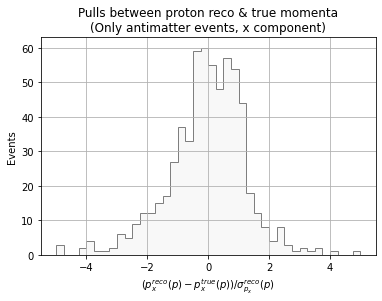

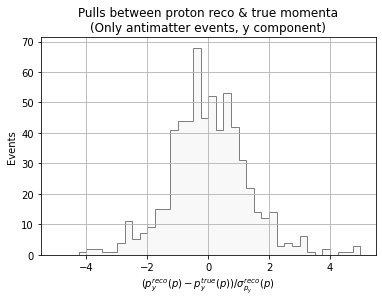

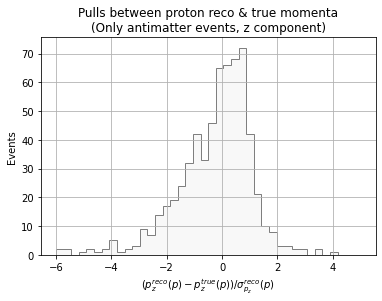

In [36]:
bias_boundary_dictionary = {
    'x': (-5,5),
    'y': (-5,5),
    'z': (-6,5)
}

for comp in ['x', 'y', 'z']:
    reco_feature = 'p_AtTrueVtx_P_' + comp.upper()
    true_feature = 'MCTRUTH_p_P' + comp.upper()
    reco_error = 'p_AtTrueVtx_P_' + comp.upper() + 'ERR'

    plot_args = {
        'axis_label': '$(p^{reco}_' +  comp + '(p) - p^{true}_' +  comp + '(p))/\sigma_{p_' +  comp + '}^{reco} (p)$',
        'plot_title': 'Pulls between proton reco & true momenta\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'p_momentum_residual_' + comp + '_rel',
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': True,
        'normalized': False
    }

    plot_single_histogram(
        (df_events[reco_feature] - df_events[true_feature])/df_events[reco_error],
        **plot_args)

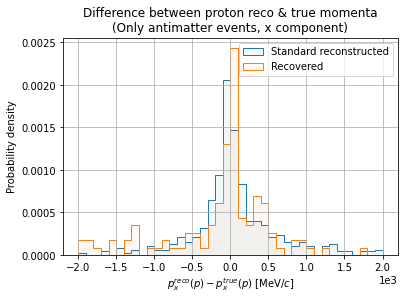

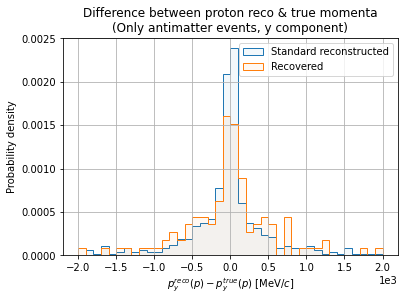

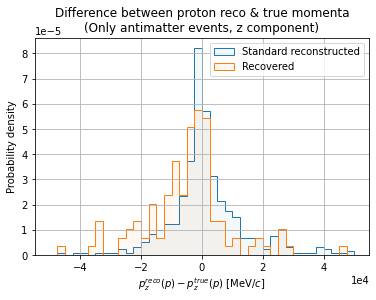

In [37]:
bias_boundary_dictionary = {
    'x': (-2e3,2e3),
    'y': (-2e3,2e3),
    'z': (-5e4,5e4)
}

for comp in ['x', 'y', 'z']:
    reco_feature = 'p_AtTrueVtx_P_' + comp.upper()
    true_feature = 'MCTRUTH_p_P' + comp.upper()

    plot_args = {
        'axis_label': '$p^{reco}_' +  comp + '(p) - p^{true}_' +  comp + '(p)$ [MeV/$c$]',
        'plot_title': 'Difference between proton reco & true momenta\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'p_momentum_residual_2Dv3D_' + comp,
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': True,
        'normalized': True
    }

    plot_2D_vs_3D_histograms(
        df_events,
        df_events[reco_feature] - df_events[true_feature],
        **plot_args)

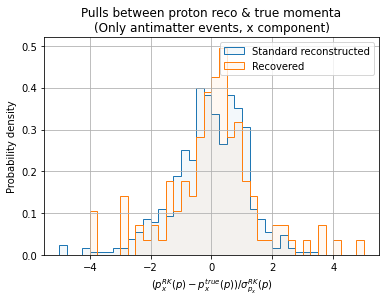

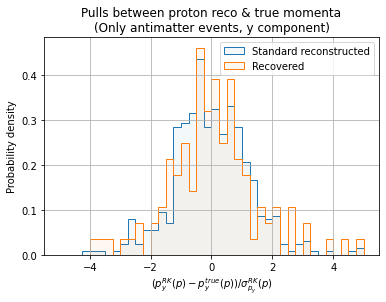

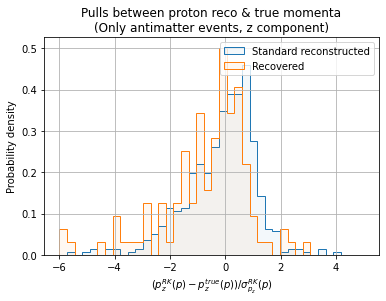

In [38]:
bias_boundary_dictionary = {
    'x': (-5,5),
    'y': (-5,5),
    'z': (-6,5)
}

for comp in ['x', 'y', 'z']:
    reco_feature = 'p_AtTrueVtx_P_' + comp.upper()
    true_feature = 'MCTRUTH_p_P' + comp.upper()
    reco_error = 'p_AtTrueVtx_P_' + comp.upper() + 'ERR'

    plot_args = {
        'axis_label': '$(p^{RK}_' +  comp + '(p) - p^{true}_' +  comp + '(p))/\sigma_{p_' +  comp + '}^{RK} (p)$',
        'plot_title': 'Pulls between proton reco & true momenta\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'p_momentum_residual_2Dv3D_' + comp + '_rel',
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': True,
        'normalized': True
    }

    plot_2D_vs_3D_histograms(
        df_events,
        (df_events[reco_feature] - df_events[true_feature])/df_events[reco_error],
        **plot_args)

## Pion momentum

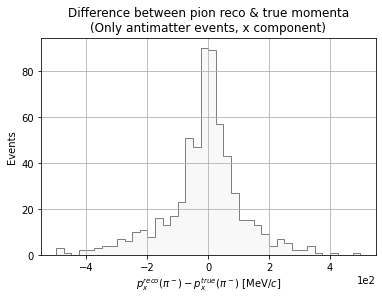

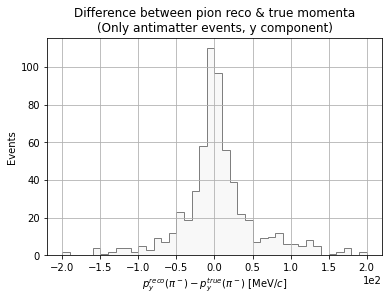

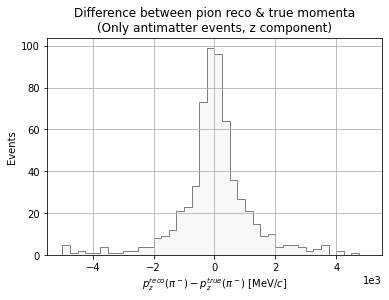

In [39]:
bias_boundary_dictionary = {
    'x': (-5e2,5e2),
    'y': (-2e2,2e2),
    'z': (-5e3,5e3)
}

for comp in ['x', 'y', 'z']:
    reco_feature = 'pim_AtTrueVtx_P_' + comp.upper()
    true_feature = 'MCTRUTH_pim_P' + comp.upper()

    plot_args = {
        'axis_label': '$p^{reco}_' +  comp + '(\pi^-) - p^{true}_' +  comp + '(\pi^-)$ [MeV/$c$]',
        'plot_title': 'Difference between pion reco & true momenta\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'pim_momentum_residual_' + comp,
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': True,
        'normalized': False
    }

    plot_single_histogram(
        df_events[reco_feature] - df_events[true_feature],
        **plot_args)

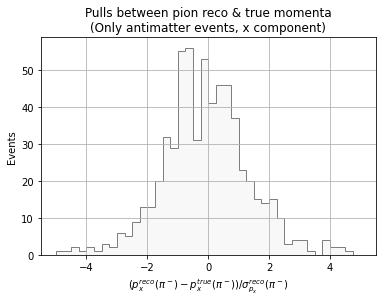

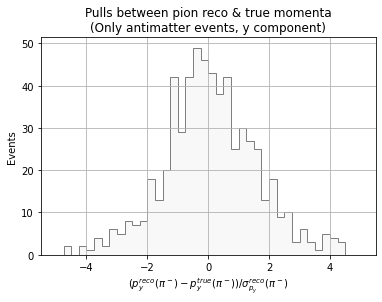

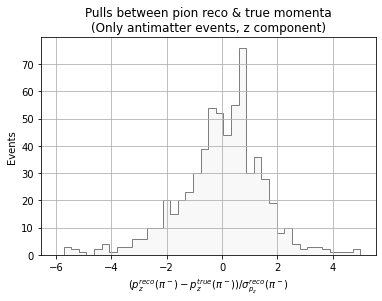

In [40]:
bias_boundary_dictionary = {
    'x': (-5,5),
    'y': (-5,5),
    'z': (-6,5)
}

for comp in ['x', 'y', 'z']:
    reco_feature = 'pim_AtTrueVtx_P_' + comp.upper()
    true_feature = 'MCTRUTH_pim_P' + comp.upper()
    reco_error = 'pim_AtTrueVtx_P_' + comp.upper() + 'ERR'

    plot_args = {
        'axis_label': '$(p^{reco}_' +  comp + '(\pi^-) - p^{true}_' +  comp + '(\pi^-))/\sigma_{p_' +  comp + '}^{reco} (\pi^-)$',
        'plot_title': 'Pulls between pion reco & true momenta\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'pim_momentum_residual_' + comp + '_rel',
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': True,
        'normalized': False
    }

    plot_single_histogram(
        (df_events[reco_feature] - df_events[true_feature])/df_events[reco_error],
        **plot_args)

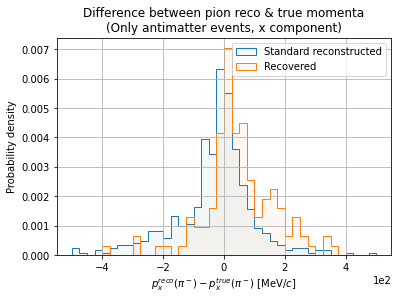

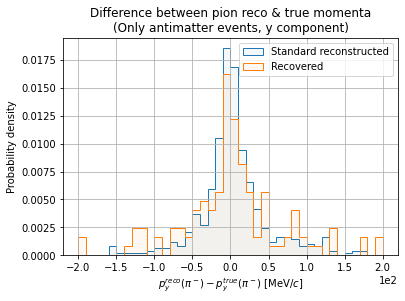

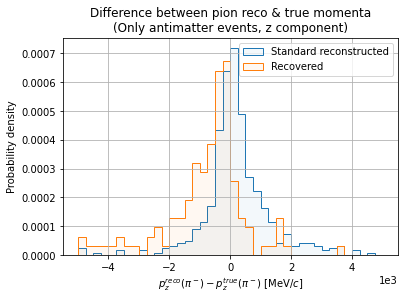

In [41]:
bias_boundary_dictionary = {
    'x': (-5e2,5e2),
    'y': (-2e2,2e2),
    'z': (-5e3,5e3)
}

for comp in ['x', 'y', 'z']:
    reco_feature = 'pim_AtTrueVtx_P_' + comp.upper()
    true_feature = 'MCTRUTH_pim_P' + comp.upper()

    plot_args = {
        'axis_label': '$p^{reco}_' +  comp + '(\pi^-) - p^{true}_' +  comp + '(\pi^-)$ [MeV/$c$]',
        'plot_title': 'Difference between pion reco & true momenta\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'pim_momentum_residual_2Dv3D_' + comp,
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': True,
        'normalized': True
    }

    plot_2D_vs_3D_histograms(
        df_events,
        df_events[reco_feature] - df_events[true_feature],
        **plot_args)

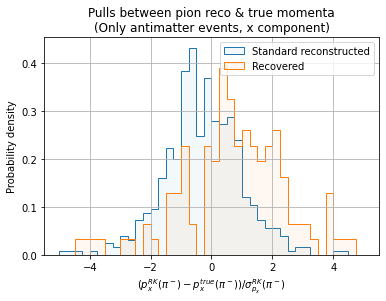

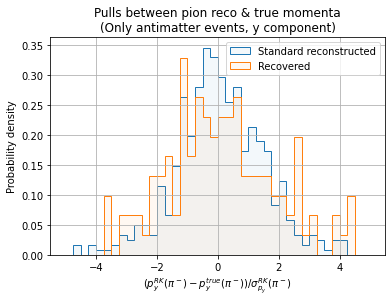

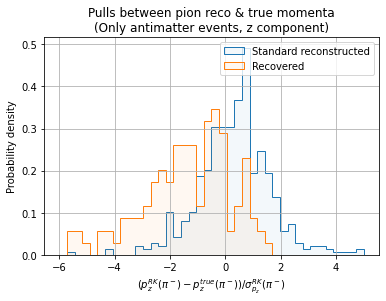

In [42]:
bias_boundary_dictionary = {
    'x': (-5,5),
    'y': (-5,5),
    'z': (-6,5)
}

for comp in ['x', 'y', 'z']:
    reco_feature = 'pim_AtTrueVtx_P_' + comp.upper()
    true_feature = 'MCTRUTH_pim_P' + comp.upper()
    reco_error = 'pim_AtTrueVtx_P_' + comp.upper() + 'ERR'

    plot_args = {
        'axis_label': '$(p^{RK}_' +  comp + '(\pi^-) - p^{true}_' +  comp + '(\pi^-))/\sigma_{p_' +  comp + '}^{RK} (\pi^-)$',
        'plot_title': 'Pulls between pion reco & true momenta\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'pim_momentum_residual_2Dv3D_' + comp + '_rel',
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': True,
        'normalized': True
    }

    plot_2D_vs_3D_histograms(
        df_events,
        (df_events[reco_feature] - df_events[true_feature])/df_events[reco_error],
        **plot_args)

# Monte Carlo residual check
`MCTRUTH_*_AtTrueVtx` values are extrapolated at true vertex via the questionably attained Monte Carlo protoparticle. Let's see if they match what we expect.

## $p,\pi^-$ reference point $=$ $\Lambda^0$ decay vertex

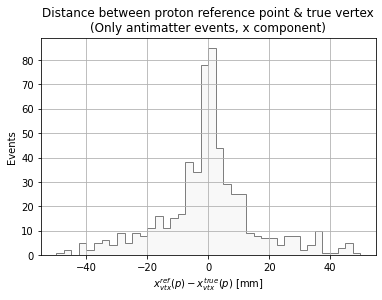

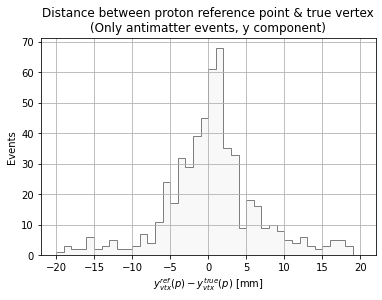

In [43]:
bias_boundary_dictionary = {
    'x': (-50,50),
    'y': (-20,20),
}

for comp in ['x', 'y']:
    reco_feature = 'MCTRUTH_p_AtTrueVtx_REFP_' + comp.upper()
    true_feature = 'MCTRUTH_L_ENDVERTEX_' + comp.upper()

    plot_args = {
        'axis_label': '$' + comp + '^{ref}_{vtx}(p) - ' + comp + '^{true}_{vtx}(p)$ [mm]',
        'plot_title': 'Distance between proton reference point & true vertex\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'p_refpoint_residual_' + comp,
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': False,
        'normalized': False
    }

    plot_single_histogram(
        df_events[reco_feature] - df_events[true_feature],
        **plot_args)

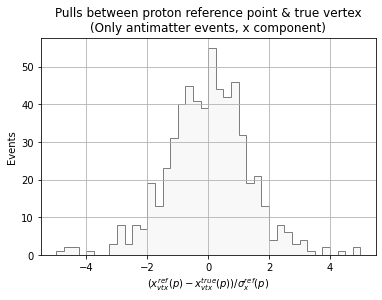

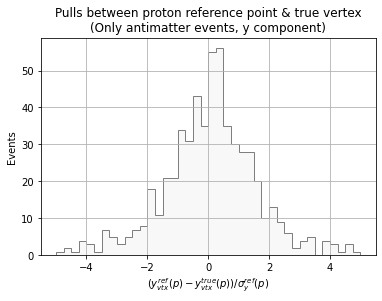

In [44]:
bias_boundary_dictionary = {
    'x': (-5,5),
    'y': (-5,5),
}

for comp in ['x', 'y']:
    reco_feature = 'MCTRUTH_p_AtTrueVtx_REFP_' + comp.upper()
    true_feature = 'MCTRUTH_L_ENDVERTEX_' + comp.upper()
    reco_error = 'MCTRUTH_p_AtTrueVtx_REFP_' + comp.upper() + 'ERR'

    plot_args = {
        'axis_label': '$(' + comp + '^{ref}_{vtx}(p) - ' + comp + '^{true}_{vtx}(p))/\sigma_' +  comp + '^{ref} (p)$',
        'plot_title': 'Pulls between proton reference point & true vertex\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'p_refpoint_residual_' + comp + '_rel',
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': False,
        'normalized': False
    }

    plot_single_histogram(
        (df_events[reco_feature] - df_events[true_feature])/df_events[reco_error],
        **plot_args)

In [45]:
df_events['p_AtFirstMeas_REFP_Z']

0       7668.2890
2       7754.7872
4       7751.8398
9       7853.5123
11      7754.7872
          ...    
1284    7916.9185
1285    7979.0718
1286    7979.0718
1287    7668.2890
1289    7862.7452
Name: p_AtFirstMeas_REFP_Z, Length: 653, dtype: float64

In [46]:
df_events['MCTRUTH_p_AtFirstMeas_REFP_Z']

0       7668.2890
2       7754.7872
4       7751.8398
9       7853.5123
11      7754.7872
          ...    
1284    7916.9185
1285    7979.0718
1286    7979.0718
1287    7668.2890
1289    7862.7452
Name: MCTRUTH_p_AtFirstMeas_REFP_Z, Length: 653, dtype: float64

# vertex

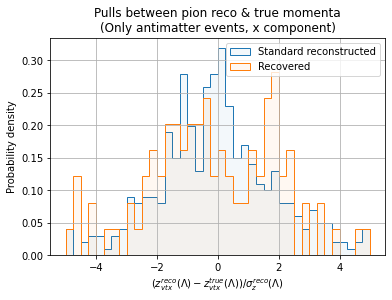

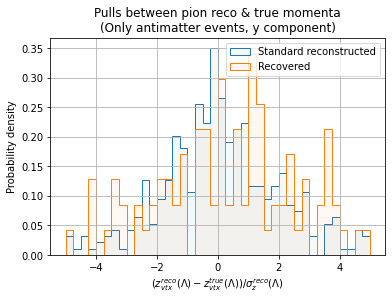

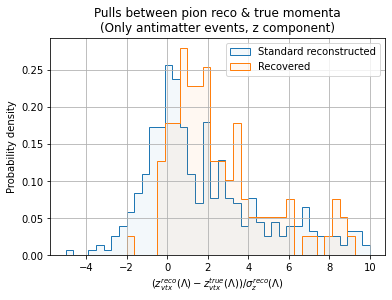

In [47]:
bias_boundary_dictionary = {
    'x': (-5,5),
    'y': (-5,5),
    'z': (-5,10)
}

for comp in ['x', 'y', 'z']:
    reco_feature = 'L_ENDVERTEX_' + comp.upper()
    true_feature = 'MCTRUTH_L_ENDVERTEX_' + comp.upper()
    reco_error = 'L_ENDVERTEX_' + comp.upper() + 'ERR'

    plot_args = {
        'axis_label': '$(z_{vtx}^{reco}(\Lambda) - z_{vtx}^{true}(\Lambda))/\sigma_{z}^{reco} (\Lambda)$',
        'plot_title': 'Pulls between pion reco & true momenta\n(' + event_category_label + ', ' + comp + " component)",
        'file_name': 'L_ENDVERTEX_residual_2Dv3D_' + comp + '_rel',
        'binning': 40,
        'boundaries': bias_boundary_dictionary[comp],
        'log_scale': False,
        'scientific_notation': False,
        'normalized': True
    }

    plot_2D_vs_3D_histograms(
        df_events,
        (df_events[reco_feature] - df_events[true_feature])/df_events[reco_error],
        **plot_args)

In [48]:
comp='z'
is_VF = df_events['L_ALGO_ID'] == 'VertexFitter'
reco_feature = 'L_ENDVERTEX_' + comp.upper()
true_feature = 'MCTRUTH_L_ENDVERTEX_' + comp.upper()
reco_error = 'L_ENDVERTEX_' + comp.upper() + 'ERR'
((df_events[reco_feature] - df_events[true_feature])/df_events[reco_error]).median()

2.0935019480469332

In [49]:
((df_events[reco_feature] - df_events[true_feature])/df_events[reco_error]).loc[is_VF].median()

1.980369142084509

In [50]:
((df_events[reco_feature] - df_events[true_feature])/df_events[reco_error]).loc[~is_VF].median()

2.6561681205168775

In [51]:
((df_events[reco_feature] - df_events[true_feature])).loc[is_VF].median()

483.7647565649095

In [52]:
((df_events[reco_feature] - df_events[true_feature])).loc[~is_VF].median()

682.6683970536935